Ask the following questions and look for the answers using code and plots:
Can you count something interesting?
Can you find trends (e.g. high, low, increasing, decreasing, anomalies)?
Can you make a bar plot or a histogram?
Can you compare two related quantities?
Can you make a scatterplot?
Can you make a time-series plot?
Looking at the plots, what are some insights you can make? Do you see any correlations? Is there a hypothesis you’d like to investigate further? What other questions do the insights lead you to ask?
Now that you’ve asked questions, hopefully you’ve found some interesting insights. Is there a narrative or a way of presenting the insights using text and plots that tells a compelling story? What are some other trends/relationships you think will make the story more complete?

In [248]:
import csv 
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
from pylab import savefig
from datetime import datetime


working_file_path = '/Users/alexia/Documents/Springboard/Capstone1/Cap1testing/'
working_file = working_file_path + 'final_20190918-152744.csv'
col_info_file = working_file_path + 'Extract9ColMapping.csv'
cols_to_drop_file = working_file_path + 'Extract9ColsToDrop.csv'
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
log_file = working_file_path + 'results' + timestamp + '.txt'
years = mdates.YearLocator() 

df_final = pd.read_csv(working_file, index_col = 'YEAR') 

HTN_colname = ["Ever told had hypertension"]

#for analysis of hypertension, filter dataset where respondent stated 
#they were told they had hypertension
df_HTN = df_final[df_final[HTN_column]==2]

print(df_final.shape)
print(df_HTN.shape)

#can only map codes to descriptions if change column datatype - do in future version, 
#when also change it for ML models
#Codes_1279 = {1: "No", 2: "Yes", 7:"Refused", 9:"Don't Know"}

#df_final['Ever told had hypertension'] = df_final['Ever told had hypertension'].map(Codes_1279)
#df_final['Ever told had angina pectoris'] = df_final['Ever told had angina pectoris'].map(Codes_1279)

#df_HTN_ANG = df_final.groupby(['Ever told had hypertension', 'Ever told had angina pectoris']).size().reset_index(name='counts')



(484750, 39)
(484750, 39)


In [249]:
df_HTN.head()df_final[HTN_column]==2


SyntaxError: invalid syntax (<ipython-input-249-4cc42ec5b9ba>, line 1)

### Examine the sample sizes in the final dataset vs the original dataset

#### This shows a big difference in sample sizes, and the final dataset having fewer samples (cut off at 2000) but the variability seems to agree...

In [ ]:
unfiltered_file = working_file_path + 'nhis_00010.csv'
df_uf = pd.read_csv(unfiltered_file, index_col = 'YEAR')

#fig = plt.figure(num=None, figsize=(15, 7))
fig, ax = plt.subplots(figsize=(15,7))
ax = df_uf.index.value_counts().sort_index().plot()
df_final.index.value_counts().sort_index().plot(ax=ax, color='r')


### Examine hypertension responses over samples

Because the sample sizes differ from year to year, we need to plot the percent of hypertension in the sample size 
in order to evaluate if there is any trend in hypertension over time.

To plot this, we need the data in the form of 

Year |  Total Responses  |  % Hypertension Positive Responses

In [ ]:
#we have year & total responses in value_counts for the whole dataframe
total_responses_by_year = df_final.index.value_counts().sort_index()
response_counts = total_responses_by_year.values.tolist()

#calculate the number of responses that indicated hypertension per year
df_HTN_by_year = df_HTN.groupby(level=0, axis=0).count()[HTN_column]

#add a column with the total responses per year 
df_HTN_by_year['total_responses_per_year'] = response_counts

#calculate the percentage of responses indicating hypertension in the total responses per year
df_HTN_by_year['pct_htn'] = df_HTN_by_year[HTN_column].apply(lambda x : x / df_HTN_by_year['total_responses_per_year'])

#examine the data
df_HTN_by_year.head()


In [ ]:
#plot the results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
df_HTN_by_year['pct_htn'].plot(ax=axes[0], color= 'r', title='Not starting Y at Zero')
#if we don't start Y at zero, the results look extreme!
df_HTN_by_year['pct_htn'].plot(ax=axes[1], color= 'r', title='Starting Y at Zero')
axes[1].set_ylim(bottom=0)
axes[0].set_ylabel('Report of Hypertension')

### Examine the distribution of data by region

In [ ]:
#map the codes in the region column to understandable names
regions = {1:'Northeast',
 2:'North Central/Midwest', 
 3:'South',
 4:'West',
 8:'NO DATA IN ROUND',
 9:'Unknown'}

df_final['Region of residence'] = df_final['Region of residence'].map(regions)

In [ ]:
#calculate the number of survey responses by region
df_reg = df_final.groupby('Region of residence').size().reset_index(name='Sample size')
df_reg.set_index('Region of residence', inplace=True)
print(df_reg)

In [ ]:
df_regionHTN = df_final.groupby(['Region of residence', 'Ever told had hypertension']).size().reset_index(name='Pos HTN')
df_regionHTN = df_regionHTN[df_regionHTN['Ever told had hypertension'] == 2][['Region of residence', 'Pos HTN']]
df_regionHTN.set_index('Region of residence', inplace=True)
print(df_regionHTN)

In [ ]:
#fig_R, ax_R = plt.subplots(figsize=(15,7))
ax_R = df_reg.plot(kind='bar', color='g')
df_regionHTN.plot(ax=ax_R, kind='bar', color='r') #,sharex=False
plt.show()

### This is helpful but it is hard to determine the percentage of hypertension because the sample sizes are so different.
It would be more helpful to see a normalized percentage.

In [ ]:
df_regiondata = pd.merge(df_regionHTN, df_reg, how='inner', on='Region of residence')
print(df_regiondata)

In [ ]:
# From totals value to percentages
#https://python-graph-gallery.com/13-percent-stacked-barplot/
#Subgroups are displayed on of top of each other, 
#but data are normalised to make in sort that the sum of every subgroups is 100.

r = [0,1,2,3]
barWidth = 0.85
names = ('North Central/Midwest','Northeast','South','West')

totals = [i+j for i,j in zip(df_regiondata['Pos HTN'], df_regiondata['Sample size'])]
HTNBars = [i / j * 100 for i,j in zip(df_regiondata['Pos HTN'], totals)]
SampleSizeBars = [i / j * 100 for i,j in zip(df_regiondata['Sample size'], totals)]
# Create HTN Bars
plt.bar(r, HTNBars, color='r', edgecolor='white', width=barWidth)
# Create SampleSize Bars
plt.bar(r, SampleSizeBars, bottom=HTNBars, color='g', edgecolor='white', width=barWidth)

# Custom x axis
plt.xticks(r, names)
plt.xlabel("Region")

plt.show()


### Is there any relationship between exercise and income?
No: exercise is low across the board

In [ ]:
y_var = 'Frequency of moderate activity 10+ minutes: Times per week'
x_var = "Person's total earnings, previous calendar year"
#filter out "unknown, unascertained responses"
df_filtered = df_final[df_final[y_var]<50]
df_filtered = df_filtered[df_filtered[x_var]<50]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
df_filtered_2000 = df_filtered.loc[[2000]]
df_filtered_2000.plot(ax=axes[0], kind='scatter', x=x_var, y=y_var, title='Year 2000', color='b')
df_filtered_2018 = df_filtered.loc[[2018]]
df_filtered_2018.plot(ax=axes[1], kind='scatter', x=x_var, y=y_var, title='Year 2018', color='b')
plt.show

### Examine the distribution of data by gender

In [ ]:
gender = {1:'Male',
 2:'Female'} 

df_final['Sex'] = df_final['Sex'].map(gender)
print(df_final['Sex'].value_counts(normalize=True))

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
df_final['Sex'].value_counts().plot(kind='bar')

#ax_R = df_reg.plot(kind='bar', color='g')
#df_regionHTN.plot(ax=ax_R, kind='bar', color='r') #,sharex=False



In [ ]:


#scatter matrix over comorbidities
#ver 1 - with "don't know" etc. include
#ver 2 - reduce values to yes and no (2 and 1) only for 4-quadrant grids
#show was looked like 20 years ago and today

matrix_cols = ['Ever told had hypertension','Ever told had angina pectoris', 'Ever told had heart condition/disease']
matrix_cols += ['Ever told had heart attack', 'Ever told had diabetes', 'Ever told had emphysema']
#scatter matrix
data = df_final.loc[2000][matrix_cols]
pd.plotting.scatter_matrix(data, figsize = (20, 20))
plt.show()





In [ ]:
sns.stripplot('Ever told had hypertension', 'Ever told had angina pectoris', data=df_final, jitter=0.1)

Relationships between categorical variables is better represented with contingency tables 


# Comorbidities

In [ ]:
#create contingency tables for hypertension compared to other variables

df_HTN_ANG = df_final.groupby(['Ever told had hypertension', 'Ever told had angina pectoris']).size().reset_index(name='counts')
df2 = df_HTN_ANG.pivot(index='Ever told had hypertension', columns = 'Ever told had angina pectoris', values='counts')
print(df2)                 

#### Contingency table for hypertension and angina

In [ ]:
pd.crosstab(index=df_final['Ever told had hypertension'], 
            columns=df_final['Ever told had angina pectoris'], 
            colnames=['Ever told had angina pectoris'],
            margins=True,
            margins_name='#Responses').rename(columns={1: "No", 2: "Yes", 7:"Refused", 9:"Don't Know"}, index={1: "No", 2: "Yes", 7:"Refused", 9:"Don't Know"})


### Respondents with HTN who reported angina: 6%

In [267]:
pd.crosstab(index=df_final['Ever told had hypertension'], 
            columns=df_final['Ever told had angina pectoris'], 
            colnames=['Angina'],
            normalize='index').rename(columns={1: "No", 2: "Yes", 7:"Refused", 9:"Don't Know"}, index={1: "No", 2: "Yes", 7:"Refused", 9:"Don't Know"})


Angina,No,Yes,Refused,Don't Know
Ever told had hypertension,,,,
No,0.989796,0.009606,0.000078,0.000519
Yes,0.935990,0.060408,0.000067,0.003534
Refused,0.383117,0.006494,0.603896,0.006494
Don't Know,0.801075,0.043011,0.002688,0.153226


### Respondents with angina who reported HTN: 76%

In [268]:
pd.crosstab(index=df_final['Ever told had hypertension'], 
            columns=df_final['Ever told had angina pectoris'], 
            colnames=['Angina'],
            normalize='columns').rename(columns={1: "No", 2: "Yes", 7:"Refused", 9:"Don't Know"}, index={1: "No", 2: "Yes", 7:"Refused", 9:"Don't Know"})


Angina,No,Yes,Refused,Don't Know
Ever told had hypertension,,,,
No,0.672245,0.235886,0.112108,0.205955
Yes,0.326871,0.762731,0.049327,0.720844
Refused,0.000251,0.000154,0.834081,0.002481
Don't Know,0.000633,0.001229,0.004484,0.070720


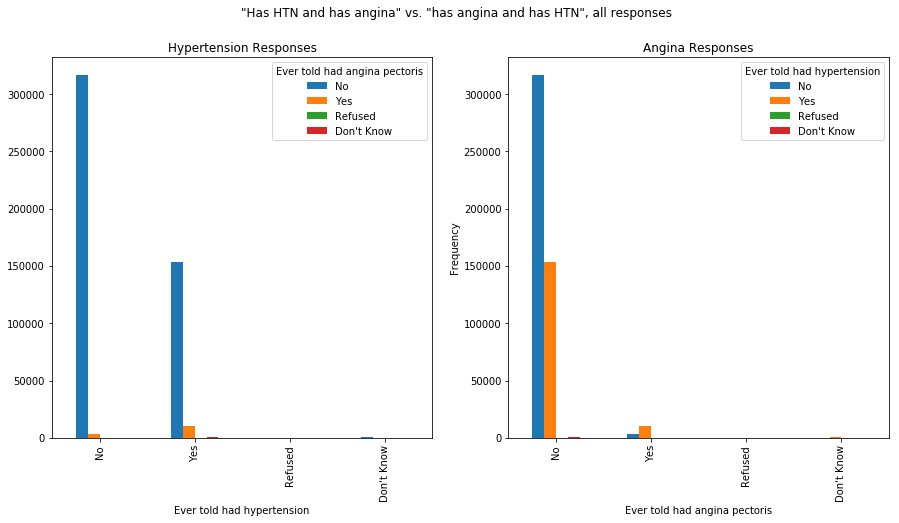

In [294]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
fig.suptitle('"Has HTN and has angina" vs. "has angina and has HTN", all responses')
pd.crosstab(index=df_final['Ever told had hypertension'], 
            columns=df_final['Ever told had angina pectoris'], 
            colnames=['Ever told had angina pectoris']).rename(columns={1: "No", 2: "Yes", 7:"Refused", 9:"Don't Know"}, index={1: "No", 2: "Yes", 7:"Refused", 9:"Don't Know"}).plot(ax=axes[0], kind='bar', title='Hypertension Responses')
plt.ylabel('Frequency')
pd.crosstab(index=df_final['Ever told had angina pectoris'], 
            columns=df_final['Ever told had hypertension'], 
            colnames=['Ever told had hypertension']).rename(columns={1: "No", 2: "Yes", 7:"Refused", 9:"Don't Know"}, index={1: "No", 2: "Yes", 7:"Refused", 9:"Don't Know"}).plot(ax=axes[1], kind='bar', title='Angina Responses')

plt.show()


#### Compare counts of positive responses in each group

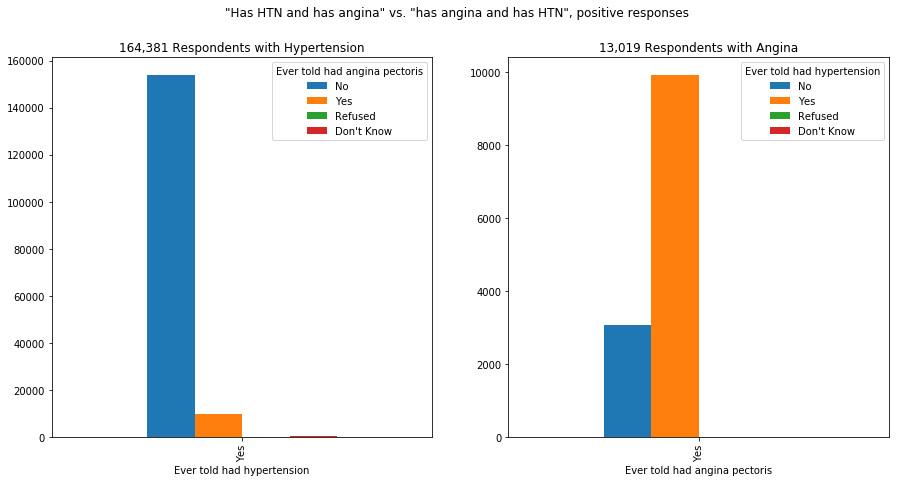

In [295]:
Codes_1279 = {1: "No", 2: "Yes", 7:"Refused", 9:"Don't Know"}
#attempted mapping dictionary over columns but was having to reassign to new dataframes every time,
#creating a lot of copies of the dataframe.  Choosing to map column names on the crosstabs instead.

df_posHTN = df_final.loc[df_final['Ever told had hypertension'] == 2]
df_posANG = df_final.loc[df_final['Ever told had angina pectoris'] == 2]
HTN_title = '{:,} Respondents with Hypertension'.format(len(df_posHTN))
ANG_title = '{:,} Respondents with Angina'.format(len(df_posANG))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
fig.suptitle('"Has HTN and has angina" vs. "has angina and has HTN", positive responses')
pd.crosstab(index=df_posHTN['Ever told had hypertension'], 
            columns=df_posHTN['Ever told had angina pectoris'], 
            colnames=['Ever told had angina pectoris']).rename(columns=Codes_1279, index=Codes_1279).plot(
            ax=axes[0], kind ='bar', title = HTN_title)
#axes[0].set_ylabel('Frequency')
#axes[0].set_ylim(0, 160000)

pd.crosstab(index=df_posANG['Ever told had angina pectoris'], 
            columns=df_posANG['Ever told had hypertension'], 
            colnames=['Ever told had hypertension']).rename(columns=Codes_1279, index=Codes_1279).plot(
            ax=axes[1], kind ='bar', title = ANG_title)

plt.show()

#### Normalize the results so the scales align

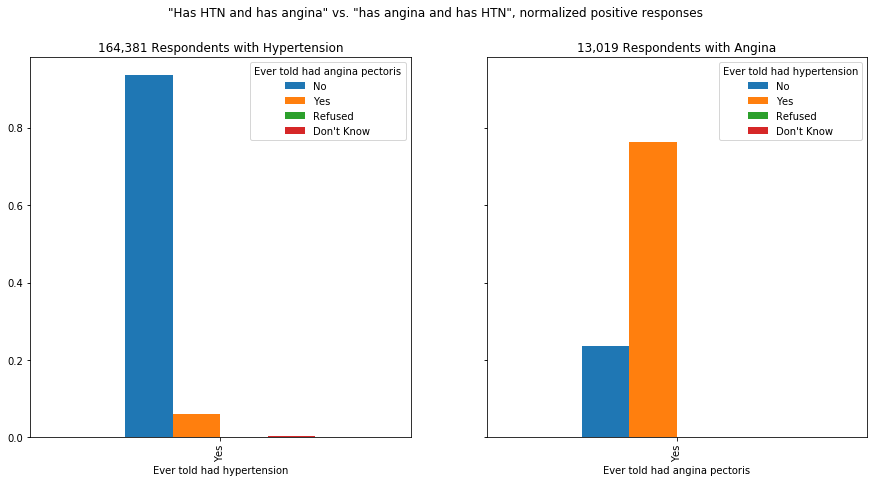

In [296]:
Codes_1279 = {1: "No", 2: "Yes", 7:"Refused", 9:"Don't Know"}
#attempted mapping dictionary over columns but was having to reassign to new dataframes every time,
#creating a lot of copies of the dataframe.  Choosing to map column names on the crosstabs instead.

df_posHTN = df_final.loc[df_final['Ever told had hypertension'] == 2]
df_posANG = df_final.loc[df_final['Ever told had angina pectoris'] == 2]
HTN_title = '{:,} Respondents with Hypertension'.format(len(df_posHTN))
ANG_title = '{:,} Respondents with Angina'.format(len(df_posANG))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7), sharey = True)
fig.suptitle('"Has HTN and has angina" vs. "has angina and has HTN", normalized positive responses')
pd.crosstab(index=df_posHTN['Ever told had hypertension'], 
            columns=df_posHTN['Ever told had angina pectoris'], 
            colnames=['Ever told had angina pectoris'],
            normalize='index').rename(columns=Codes_1279, index=Codes_1279).plot(
            ax=axes[0], kind ='bar', title = HTN_title)

pd.crosstab(index=df_posANG['Ever told had angina pectoris'], 
            columns=df_posANG['Ever told had hypertension'], 
            colnames=['Ever told had hypertension'],
            normalize='index').rename(columns=Codes_1279, index=Codes_1279).plot(
            ax=axes[1], kind ='bar', title = ANG_title)
plt.show()

### Respondents with HTN who reported asthma: 6%

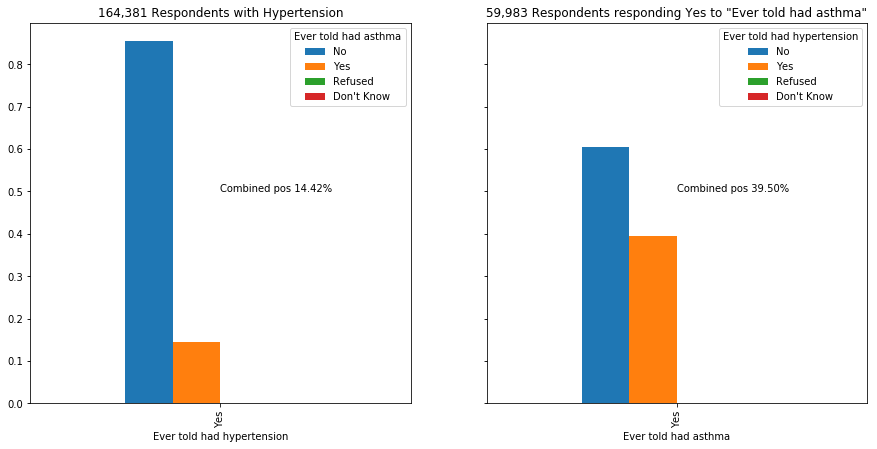

In [326]:
Codes_1279 = {1: "No", 2: "Yes", 7:"Refused", 9:"Don't Know"}
df_posHTN = df_final.loc[df_final[HTN_colname] == 2]
HTN_title = '{:,} Respondents with Hypertension'.format(len(df_posHTN))

comorbidity = 'Ever told had asthma'
df_posCmb = df_final.loc[df_final[comorbidity] == 2]
CMB_title = '{:,} Respondents responding Yes to "{}"'.format(len(df_posCmb), comorbidity)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7), sharey = True)
pd.crosstab(index=df_posHTN[HTN_colname], 
            columns=df_posHTN[comorbidity], 
            colnames=[comorbidity],
            normalize='index').rename(columns=Codes_1279, index=Codes_1279).plot(
            ax=axes[0], kind ='bar', title = HTN_title)

HTNandCMB = 'Combined pos {:.2%}'.format(len(df_posHTN.loc[df_posHTN[comorbidity]==2]) / len(df_posHTN))
axes[0].text(0, 0.5, HTNandCMB)

pd.crosstab(index=df_posCmb[comorbidity], 
            columns=df_posCmb[HTN_colname], 
            colnames=[HTN_colname],
            normalize='index').rename(columns=Codes_1279, index=Codes_1279).plot(
            ax=axes[1], kind ='bar', title = CMB_title)

CMBandHTN = 'Combined pos {:.2%}'.format(len(df_posCmb.loc[df_posCmb[HTN_colname]==2]) / len(df_posCmb))
axes[1].text(0, 0.5, CMBandHTN)


plt.show()

In [269]:
pd.crosstab(index=df_final['Ever told had hypertension'], 
            columns=df_final['Ever told had asthma'], 
            colnames=['Asthma'],
            normalize='index')

#.rename(columns={1: "No", 2: "Yes", 7:"Refused", 9:"Don't Know"}, index={1: "No", 2: "Yes", 7:"Refused", 9:"Don't Know"})



Asthma,No,Yes,Refused,Don't Know
Ever told had hypertension,,,,
No,0.886202,0.113351,0.000075,0.000372
Yes,0.854935,0.144153,0.000085,0.000827
Refused,0.516234,0.038961,0.441558,0.003247
Don't Know,0.809140,0.102151,0.010753,0.077957


#### Among the people who reported hypertension, 94% reported *not* having diabetes

In [ ]:
pd.crosstab(index=df_final['Ever told had hypertension'], 
            columns=df_final['Ever told had diabetes'], 
            colnames=['Diabetes'],
            normalize='index').rename(columns={1: "No", 2: "Yes", 3: "Borderline", 7:"Refused", 9:"Don't Know"}, index={1: "No", 2: "Yes", 7:"Refused", 9:"Don't Know"})


Among the people who reported hypertension, 94% reported not having ever had a heart attack

In [ ]:
pd.crosstab(index=df_final['Ever told had hypertension'], 
            columns=df_final['Ever told had heart attack'], 
            colnames=['Heart Attack'],
            normalize='index').rename(columns={1: "No", 2: "Yes", 7:"Refused", 9:"Don't Know"}, index={1: "No", 2: "Yes", 7:"Refused", 9:"Don't Know"})


### Plot the ability to afford care over time

In [ ]:
#confirm results
#fix formatting of year
#fix legend

y_column = ["Needed but couldn't afford medical care, past 12 months"]

#filter dataset for rows where respondent stated they could not afford medical care
df_afford = df[df["Needed but couldn't afford medical care, past 12 months"]==2]

#group the dataset by year and count the rows
years = df_afford.groupby(level=0, axis=0).count()[y_column]

#plot the data
years.plot()

# Add the title
plt.title('Inability to afford care')

# Add the y-axis label
plt.ylabel('Frequency')

# Display the plot
plt.show()

Time series
reporting hypertension over time
plot family income over time - adjusted for inflation?  (how to do that?)
ability to afford care vs hypertension reported

Distribution over other factors
hypertension by region, gender, income, ability to afford care?

Correlations
comorbidities - correlations w/ other conditions


### Distribution of Race over time

In [ ]:
#df_by_year = df_final.groupby(level=0, axis=0).count
#print(df_by_year)
#df_by_year.groupby('Main Racial Background').plot(kind='density')
#data = df_final.groupby(level=0)['Main Racial Background']
#data.plot(kind='hist')
